# Importing needed libraries

In [47]:
import cv2
import imutils
from numpy.linalg import norm
import numpy as np
cv2.__version__
import matplotlib.pyplot as plt

# Image import

In [48]:
image = cv2.imread('paragon_1.jpg')
image.shape

(600, 450, 3)

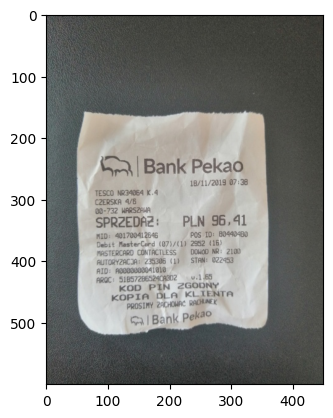

In [49]:
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))

# Reducing the image

In [50]:
orginal_image = image.copy()
ratio = image.shape[0] / 500.0
image = imutils.resize(image, height=500)
image.shape

(500, 375, 3)

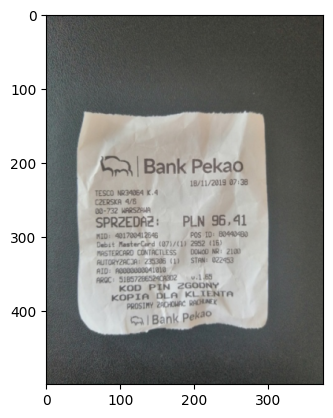

In [51]:
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))

# Morphological operation

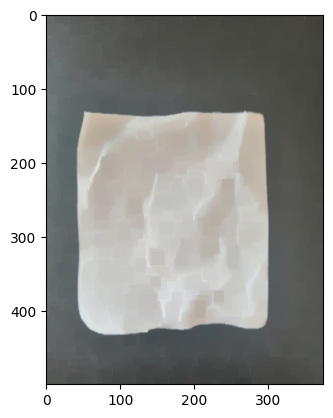

In [52]:
kernel = np.ones((5,5),np.uint8)
img = cv2.morphologyEx(image, cv2.MORPH_CLOSE, kernel, iterations= 3)
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))

In [53]:
# GrabCut operation

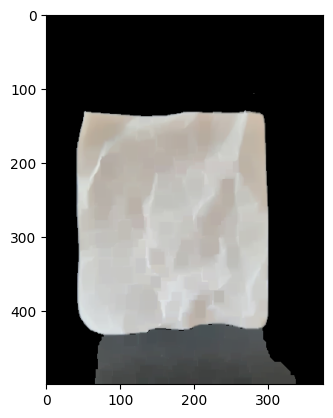

In [54]:
mask = np.zeros(img.shape[:2],np.uint8)
bgdModel = np.zeros((1,65),np.float64)
fgdModel = np.zeros((1,65),np.float64)
rect = (3,3,img.shape[1]-3,img.shape[0]-3)
cv2.grabCut(img,mask,rect,bgdModel,fgdModel,5,cv2.GC_INIT_WITH_RECT)
mask2 = np.where((mask==2)|(mask==0),0,1).astype('uint8')
img = img*mask2[:,:,np.newaxis]
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))

# Edge Detection

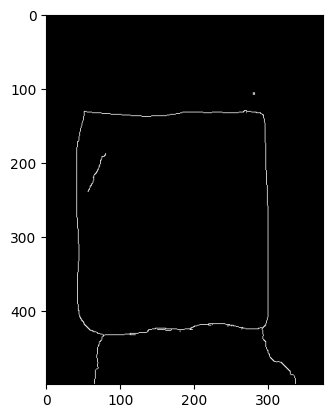

In [55]:
edges = cv2.Canny(img, threshold1=75, threshold2=200)
plt.imshow(cv2.cvtColor(edges, cv2.COLOR_BGR2RGB))

In [56]:
contours = cv2.findContours(image=edges.copy(), mode=cv2.RETR_LIST, method=cv2.CHAIN_APPROX_SIMPLE)
contours = imutils.grab_contours(contours)
print(f'Number of all found points (contour): {len(contours)}')
contours = sorted(contours, key=cv2.contourArea, reverse=True)[:5]

for contour in contours:
    print(len(contour))

Number of all found points (contour): 8
328
182
6
70
4


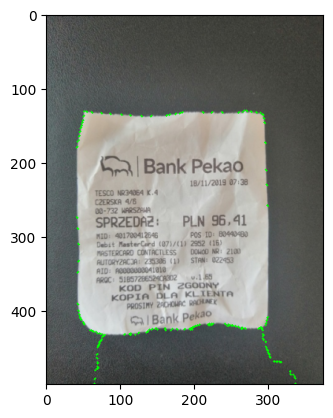

In [57]:
cnt1 = cv2.drawContours(image.copy(), contours[0], -1, (0, 255, 0), 2)
plt.imshow(cv2.cvtColor(cnt1, cv2.COLOR_BGR2RGB))

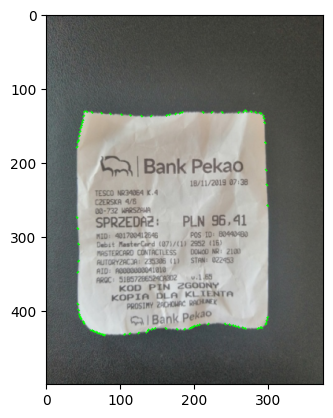

In [58]:
cnt2 = cv2.drawContours(image.copy(), contours[1], -1, (0, 255, 0), 2)
plt.imshow(cv2.cvtColor(cnt2, cv2.COLOR_BGR2RGB))

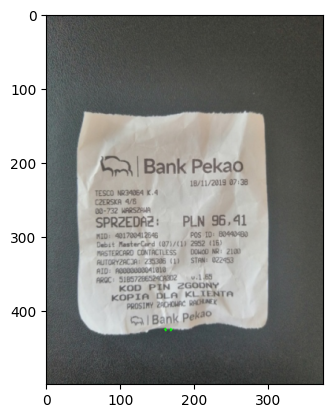

In [59]:
cnt3 = cv2.drawContours(image.copy(), contours[2], -1, (0, 255, 0), 2)
plt.imshow(cv2.cvtColor(cnt3, cv2.COLOR_BGR2RGB))

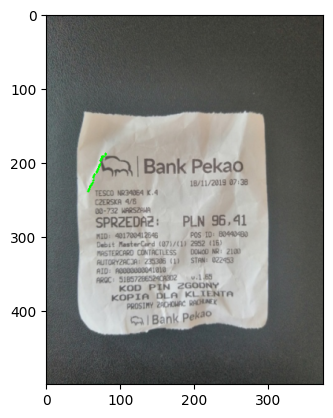

In [60]:
cnt4 = cv2.drawContours(image.copy(), contours[3], -1, (0, 255, 0), 2)
plt.imshow(cv2.cvtColor(cnt4, cv2.COLOR_BGR2RGB))

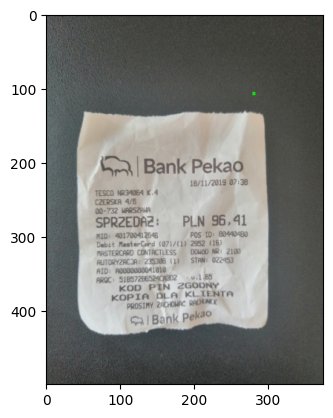

In [61]:
cnt5 = cv2.drawContours(image.copy(), contours[4], -1, (0, 255, 0), 2)
plt.imshow(cv2.cvtColor(cnt5, cv2.COLOR_BGR2RGB))

# Contour Detection

In [62]:
for contour in contours:
    print('Verification...')
    perimeter = cv2.arcLength(curve=contour, closed=True)
    
    approx = cv2.approxPolyDP(curve=contour, epsilon=0.02 * perimeter, closed=True)

    if len(approx) ==4:
        screen_contour = approx
        break
    
print(screen_contour)

Verification...
Verification...
[[[290 134]]

 [[296 419]]

 [[ 60 427]]

 [[ 51 132]]]


# Detecting the Corner Points

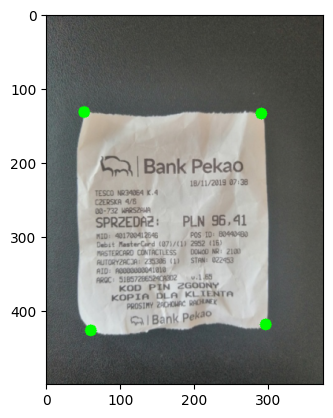

In [64]:
cv2.drawContours(image, screen_contour, -1, (0, 255, 0), 15)
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))

# Restoring the scale

In [73]:
points = screen_contour.reshape(4, 2)
points = points * ratio
points

array([[348. , 160.8],
       [355.2, 502.8],
       [ 72. , 512.4],
       [ 61.2, 158.4]])

# Rearranging the Detected Corners

In [74]:
rectanle = np.zeros((4, 2), dtype='float32')
rectanle

array([[0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.]], dtype=float32)

In [75]:
total = points.sum(axis=1)

rectanle[0] = points[np.argmin(total)]
rectanle[2] = points[np.argmax(total)]
rectanle

array([[ 61.2, 158.4],
       [  0. ,   0. ],
       [355.2, 502.8],
       [  0. ,   0. ]], dtype=float32)

In [76]:
difference = np.diff(points, axis=1)
rectanle[1] = points[np.argmin(difference)]
rectanle[3] = points[np.argmax(difference)]
rectanle

array([[ 61.2, 158.4],
       [348. , 160.8],
       [355.2, 502.8],
       [ 72. , 512.4]], dtype=float32)

In [69]:
(a, b, c, d) = rectanle

width1 = norm(c - b)
width2 = norm(b - a)
max_width = max(int(width1), int(width2))

hight1 = norm(b - c)
hight2 = norm(a - d)
max_hight = max(int(hight1), int(hight2))

print(f'max_width: {max_width}')
print(f'max_hight: {max_hight}')

max_width: 342
max_hight: 354


In [70]:
vertices = np.array([
    [0, 0],
    [max_width -1, 0],
    [max_width -1, max_hight -1],
    [0, max_hight -1]
], dtype='float32')
    
vertices

array([[  0.,   0.],
       [341.,   0.],
       [341., 353.],
       [  0., 353.]], dtype=float32)

# Perspective Transform to Align the Document

In [77]:
M =cv2.getPerspectiveTransform(rectanle, vertices)
M

array([[ 1.13505836e+00, -3.46288938e-02, -6.39803562e+01],
       [-8.15201336e-03,  9.74161878e-01, -1.53808332e+02],
       [-1.17624858e-04, -2.89984246e-05,  1.00000000e+00]])

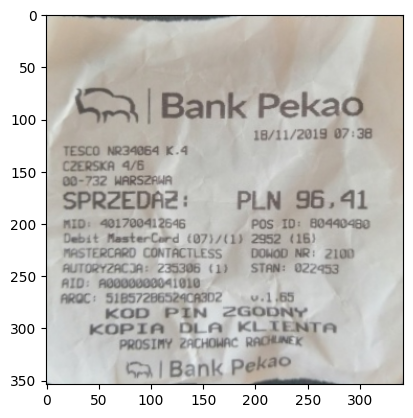

In [78]:
out = cv2.warpPerspective(src=orginal_image, M=M, dsize=(max_width, max_hight))
plt.imshow(cv2.cvtColor(out, cv2.COLOR_BGR2RGB))